# Word2Vec (Negative Sampling)

In [1]:
import time, re, os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
print("numpy:", np.__version__)
print("torch:", torch.__version__)

numpy: 2.4.1
torch: 2.9.1+cpu


## 1. Load data

In [3]:
import nltk
nltk.download("brown")
from nltk.corpus import brown

def load_news_corpus(max_sentences=20000):
    sents = brown.sents(categories="news")[:max_sentences]
    corpus = []
    for sent in sents:
        toks = [w.lower() for w in sent]
        toks = [w for w in toks if re.fullmatch(r"[a-z]+", w)]
        if len(toks) >= 2:
            corpus.append(toks)
    return corpus

corpus = load_news_corpus(max_sentences=20000)
print("num sentences:", len(corpus))
print("example:", corpus[0][:20])

num sentences: 4555
example: ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'recent', 'primary', 'election', 'produced', 'no', 'evidence', 'that', 'any', 'irregularities', 'took']


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


## 2. Build Vocabulary + Numeralization

In [4]:
from collections import Counter

def build_vocab(corpus, min_count=5, max_vocab=30000):
    counts = Counter(w for sent in corpus for w in sent)
    items = [(w,c) for w,c in counts.items() if c >= min_count]
    items.sort(key=lambda x: x[1], reverse=True)
    items = items[:max_vocab]

    vocabs = [w for w,_ in items]
    vocabs.append("<UNK>")
    word2index = {w:i for i,w in enumerate(vocabs)}
    index2word = {i:w for w,i in word2index.items()}

    # counts aligned to vocab indices
    vocab_counts = np.zeros(len(vocabs), dtype=np.int64)
    for w,c in items:
        vocab_counts[word2index[w]] = c
    # put OOV mass into <UNK> (optional)
    oov_mass = sum(c for w,c in counts.items() if w not in word2index)
    vocab_counts[word2index["<UNK>"]] = oov_mass
    return vocabs, word2index, index2word, vocab_counts

vocabs, word2index, index2word, vocab_counts = build_vocab(corpus, min_count=5, max_vocab=30000)
V = len(vocabs)
print("vocab size:", V, "top10:", vocabs[:10])

vocab size: 2373 top10: ['the', 'of', 'and', 'to', 'a', 'in', 'for', 'that', 'is', 'was']


## 3. Prepare train data

In [5]:
def make_skipgrams(corpus, word2index, window_size=2):
    unk = word2index["<UNK>"]
    pairs = []
    for sent in corpus:
        sent_ids = [word2index.get(w, unk) for w in sent]
        for i in range(len(sent_ids)):
            c = sent_ids[i]
            left = max(0, i-window_size)
            right = min(len(sent_ids), i+window_size+1)
            for j in range(left, right):
                if j == i:
                    continue
                o = sent_ids[j]
                pairs.append([c, o])
    return np.array(pairs, dtype=np.int64)

def random_batch(batch_size, pairs):
    idx = np.random.choice(len(pairs), batch_size, replace=False)
    x = pairs[idx, 0].reshape(-1, 1)
    y = pairs[idx, 1].reshape(-1, 1)
    return x, y

window_size = 2  # default required :contentReference[oaicite:2]{index=2}
pairs = make_skipgrams(corpus, word2index, window_size=window_size)
print("num pairs:", len(pairs))

num pairs: 306722


## 4. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [6]:
def neg_sampling_prob(vocab_counts, power=0.75):
    p = vocab_counts.astype(np.float64) ** power
    p = p / (p.sum() + 1e-12)
    return p

neg_prob = neg_sampling_prob(vocab_counts, power=0.75)
neg_prob[:10], neg_prob.sum()

(array([0.02984615, 0.01634387, 0.01335686, 0.01316392, 0.0130994 ,
        0.01258868, 0.0072562 , 0.0064548 , 0.00588565, 0.00578903]),
 np.float64(1.0))

## 5. Model

In [7]:
class SkipgramNEG(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.embedding_center = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

    @staticmethod
    def sigmoid(x):
        return torch.sigmoid(x)

    def forward(self, center, pos_outside, neg_outsides):
        v_c = self.embedding_center(center).squeeze(1)          # (B,E)
        u_o = self.embedding_outside(pos_outside).squeeze(1)    # (B,E)
        u_n = self.embedding_outside(neg_outsides)              # (B,K,E)

        # positive score: (B,)
        s_pos = torch.sum(v_c * u_o, dim=1)

        # negative scores: (B,K)
        s_neg = torch.einsum("be,bke->bk", v_c, u_n)

        # loss
        loss_pos = -torch.log(self.sigmoid(s_pos) + 1e-12)              # (B,)
        loss_neg = -torch.sum(torch.log(self.sigmoid(-s_neg) + 1e-12), dim=1)  # (B,)
        loss = torch.mean(loss_pos + loss_neg)
        return loss

In [8]:
def sample_negatives(batch_size, K, neg_prob, avoid_ids=None, seed=None):
    rng = np.random.default_rng(seed)
    negs = rng.choice(len(neg_prob), size=(batch_size, K), replace=True, p=neg_prob)
    if avoid_ids is not None:
        # simple resample where equals (lightweight baseline)
        for i in range(batch_size):
            for k in range(K):
                while negs[i, k] == avoid_ids[i]:
                    negs[i, k] = rng.choice(len(neg_prob), p=neg_prob)
    return negs

## 5. Training

In [9]:
batch_size = 256
emb_size = 100
lr = 0.002
num_epochs = 10000
K = 10  # number of negative samples

In [10]:
model = SkipgramNEG(V, emb_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_history = []
start = time.time()

for epoch in range(num_epochs):

    x, y = random_batch(batch_size, pairs)
    center = torch.LongTensor(x).squeeze(1)         # (B,)
    pos = torch.LongTensor(y).squeeze(1)            # (B,)

    negs_np = sample_negatives(batch_size, K, neg_prob, avoid_ids=pos.numpy())
    negs = torch.LongTensor(negs_np)                # (B,K)

    loss = model(center.unsqueeze(1), pos.unsqueeze(1), negs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 200 == 0:
        print(f"Epoch {epoch+1:4d}/{num_epochs} | Loss: {loss.item():.4f}")

train_time = time.time() - start
print("Training time (sec):", train_time)
print("final window_size:", window_size)

Epoch  200/10000 | Loss: 33.0512
Epoch  400/10000 | Loss: 24.4160
Epoch  600/10000 | Loss: 22.1317
Epoch  800/10000 | Loss: 17.9806
Epoch 1000/10000 | Loss: 15.3728
Epoch 1200/10000 | Loss: 13.2300
Epoch 1400/10000 | Loss: 11.4522
Epoch 1600/10000 | Loss: 11.4294
Epoch 1800/10000 | Loss: 9.8464
Epoch 2000/10000 | Loss: 7.7821
Epoch 2200/10000 | Loss: 7.8243
Epoch 2400/10000 | Loss: 7.4257
Epoch 2600/10000 | Loss: 6.3044
Epoch 2800/10000 | Loss: 6.1140
Epoch 3000/10000 | Loss: 6.7153
Epoch 3200/10000 | Loss: 5.4313
Epoch 3400/10000 | Loss: 4.8486
Epoch 3600/10000 | Loss: 5.1315
Epoch 3800/10000 | Loss: 4.4066
Epoch 4000/10000 | Loss: 4.9932
Epoch 4200/10000 | Loss: 4.1961
Epoch 4400/10000 | Loss: 4.3545
Epoch 4600/10000 | Loss: 4.2245
Epoch 4800/10000 | Loss: 4.4744
Epoch 5000/10000 | Loss: 4.2839
Epoch 5200/10000 | Loss: 4.1824
Epoch 5400/10000 | Loss: 3.8342
Epoch 5600/10000 | Loss: 3.5123
Epoch 5800/10000 | Loss: 3.5892
Epoch 6000/10000 | Loss: 3.6354
Epoch 6200/10000 | Loss: 3.5348


## 6. Plot loss

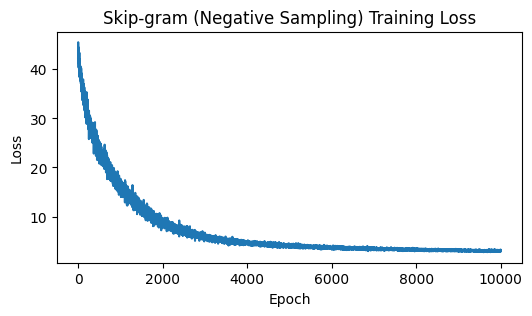

In [11]:
plt.figure(figsize=(6,3))
plt.plot(loss_history)
plt.title("Skip-gram (Negative Sampling) Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 7. Save model/embeddings

In [12]:
def export_embeddings(model):
    Wc = model.embedding_center.weight.detach().cpu().numpy()
    Wo = model.embedding_outside.weight.detach().cpu().numpy()
    return (Wc + Wo) / 2.0

emb = export_embeddings(model)

save_path = os.path.join("..", "models", f"skipgram_neg_w{window_size}.npz")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

np.savez(
    save_path,
    emb=emb,
    vocabs=np.array(vocabs, dtype=object),
    window_size=window_size,
    emb_size=emb_size,
    lr=lr,
    num_epochs=num_epochs,
    K=K,
    train_time=train_time)
print("saved to:", save_path)

saved to: ..\models\skipgram_neg_w2.npz


## 8. Sanity check

In [13]:
def cosine(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.dot(a,b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-12))

def most_similar(word, topk=10):
    idx = word2index.get(word, word2index["<UNK>"])
    q = emb[idx]
    sims = [(vocabs[i], cosine(q, emb[i])) for i in range(len(vocabs))]
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:topk]

most_similar("government", 10)

[('government', 1.0),
 ('chase', 0.4050006866455078),
 ('assemblies', 0.38538575172424316),
 ('financial', 0.3632262647151947),
 ('form', 0.2967517673969269),
 ('anything', 0.2945277690887451),
 ('states', 0.29293292760849),
 ('ordinance', 0.2922561466693878),
 ('belgian', 0.27548208832740784),
 ('british', 0.27240514755249023)]